## Boston Housing
### The Fundamentals of EDA
Magnus Skonberg | May 9th 2023

**Project Intro**

We'll be working with [The Boston Housing Dataset](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset). The dataset was gathered by the US Census Bureau regarding housing in the Boston Massachussetts area and can be obtained from the StatLib archive.

This dataset has been used extensively in academic literature and for Kaggle competitions because it can be used as a benchmark for different algorithms. The dataset is relatively small (506 observations) and contains the following variables:

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per 10,000 dollars
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in 1000s of dollars

The purpose of this project is to replicate [past group project work](https://rpubs.com/Magnus_Skonberg/755738) from my MSDS program. It's worth noting there are differences between datasets, approach, and programming language.

The purpose of this project will be to prep (clean and explore) our data, determine which factor(s) are most correlated with higher median value homes, and finally to build a linear regression model to predict home value.


### Initialize libraries and read in data

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import IsolationForest

%matplotlib inline

df = pd.read_csv('HousingData.csv')

### High level, intro EDA

In [2]:
# shape
df.shape

# summary stats
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560262,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Column descriptions are provided in the intro. What we gather from this initial read is:
* we're dealing with 506 rows x 14 columns, a relatively small dataset
* while on the surface all variables appear to be numeric, we know that CHAS should be converted to categorical
* there also appears to be a NULL presence in CRIM, ZN, INDUS, CHAS, AGE, and LSTAT

### Exploratory Data Analysis (EDA) & Data Cleaning

Next we'll perform a thorough exploratory data analysis, and preparing our data with a series of transformational steps (ie. dealing with outliers, feature engineering and removal). We then move on to building each model, exploring corresponding predictive accuracies, verifying each model’s predictive capability with our test data, and then highlighting the strongest model from those listed above.

<AxesSubplot:>

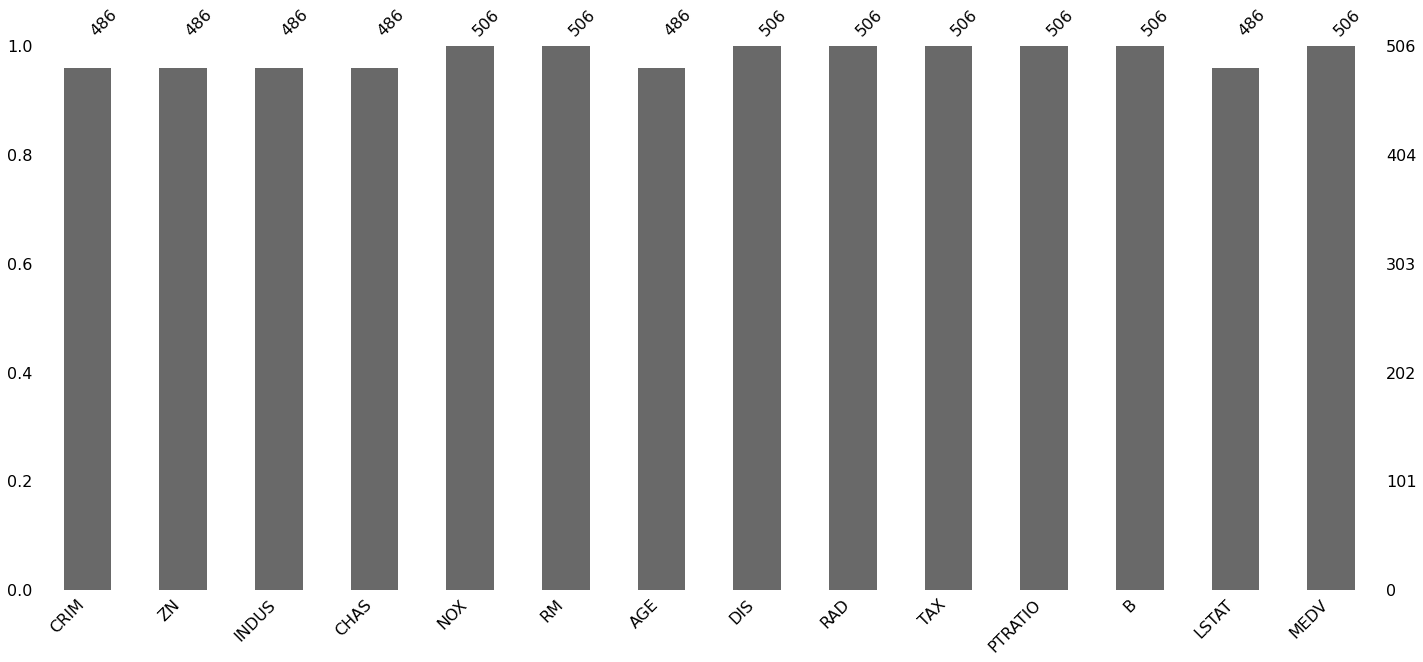

In [3]:
# Missing values
msno.bar(df)

We confirm that data is missing for CRIM, ZN, INDUS, CHAS, AGE, and LSTAT. If these columns prove to be valuable in any way then these rows should be thrown out. It's simply too much missing data.

In [4]:
# categorical interpretation (CHAS)
df['CHAS'].value_counts()

0.0    452
1.0     34
Name: CHAS, dtype: int64

From above, we gather that 452 properties are not on the Charles river while 34 are. Based on this fact and the fact that there is NULL presence in this column as well, it might be worth ignoring this variable altogether.

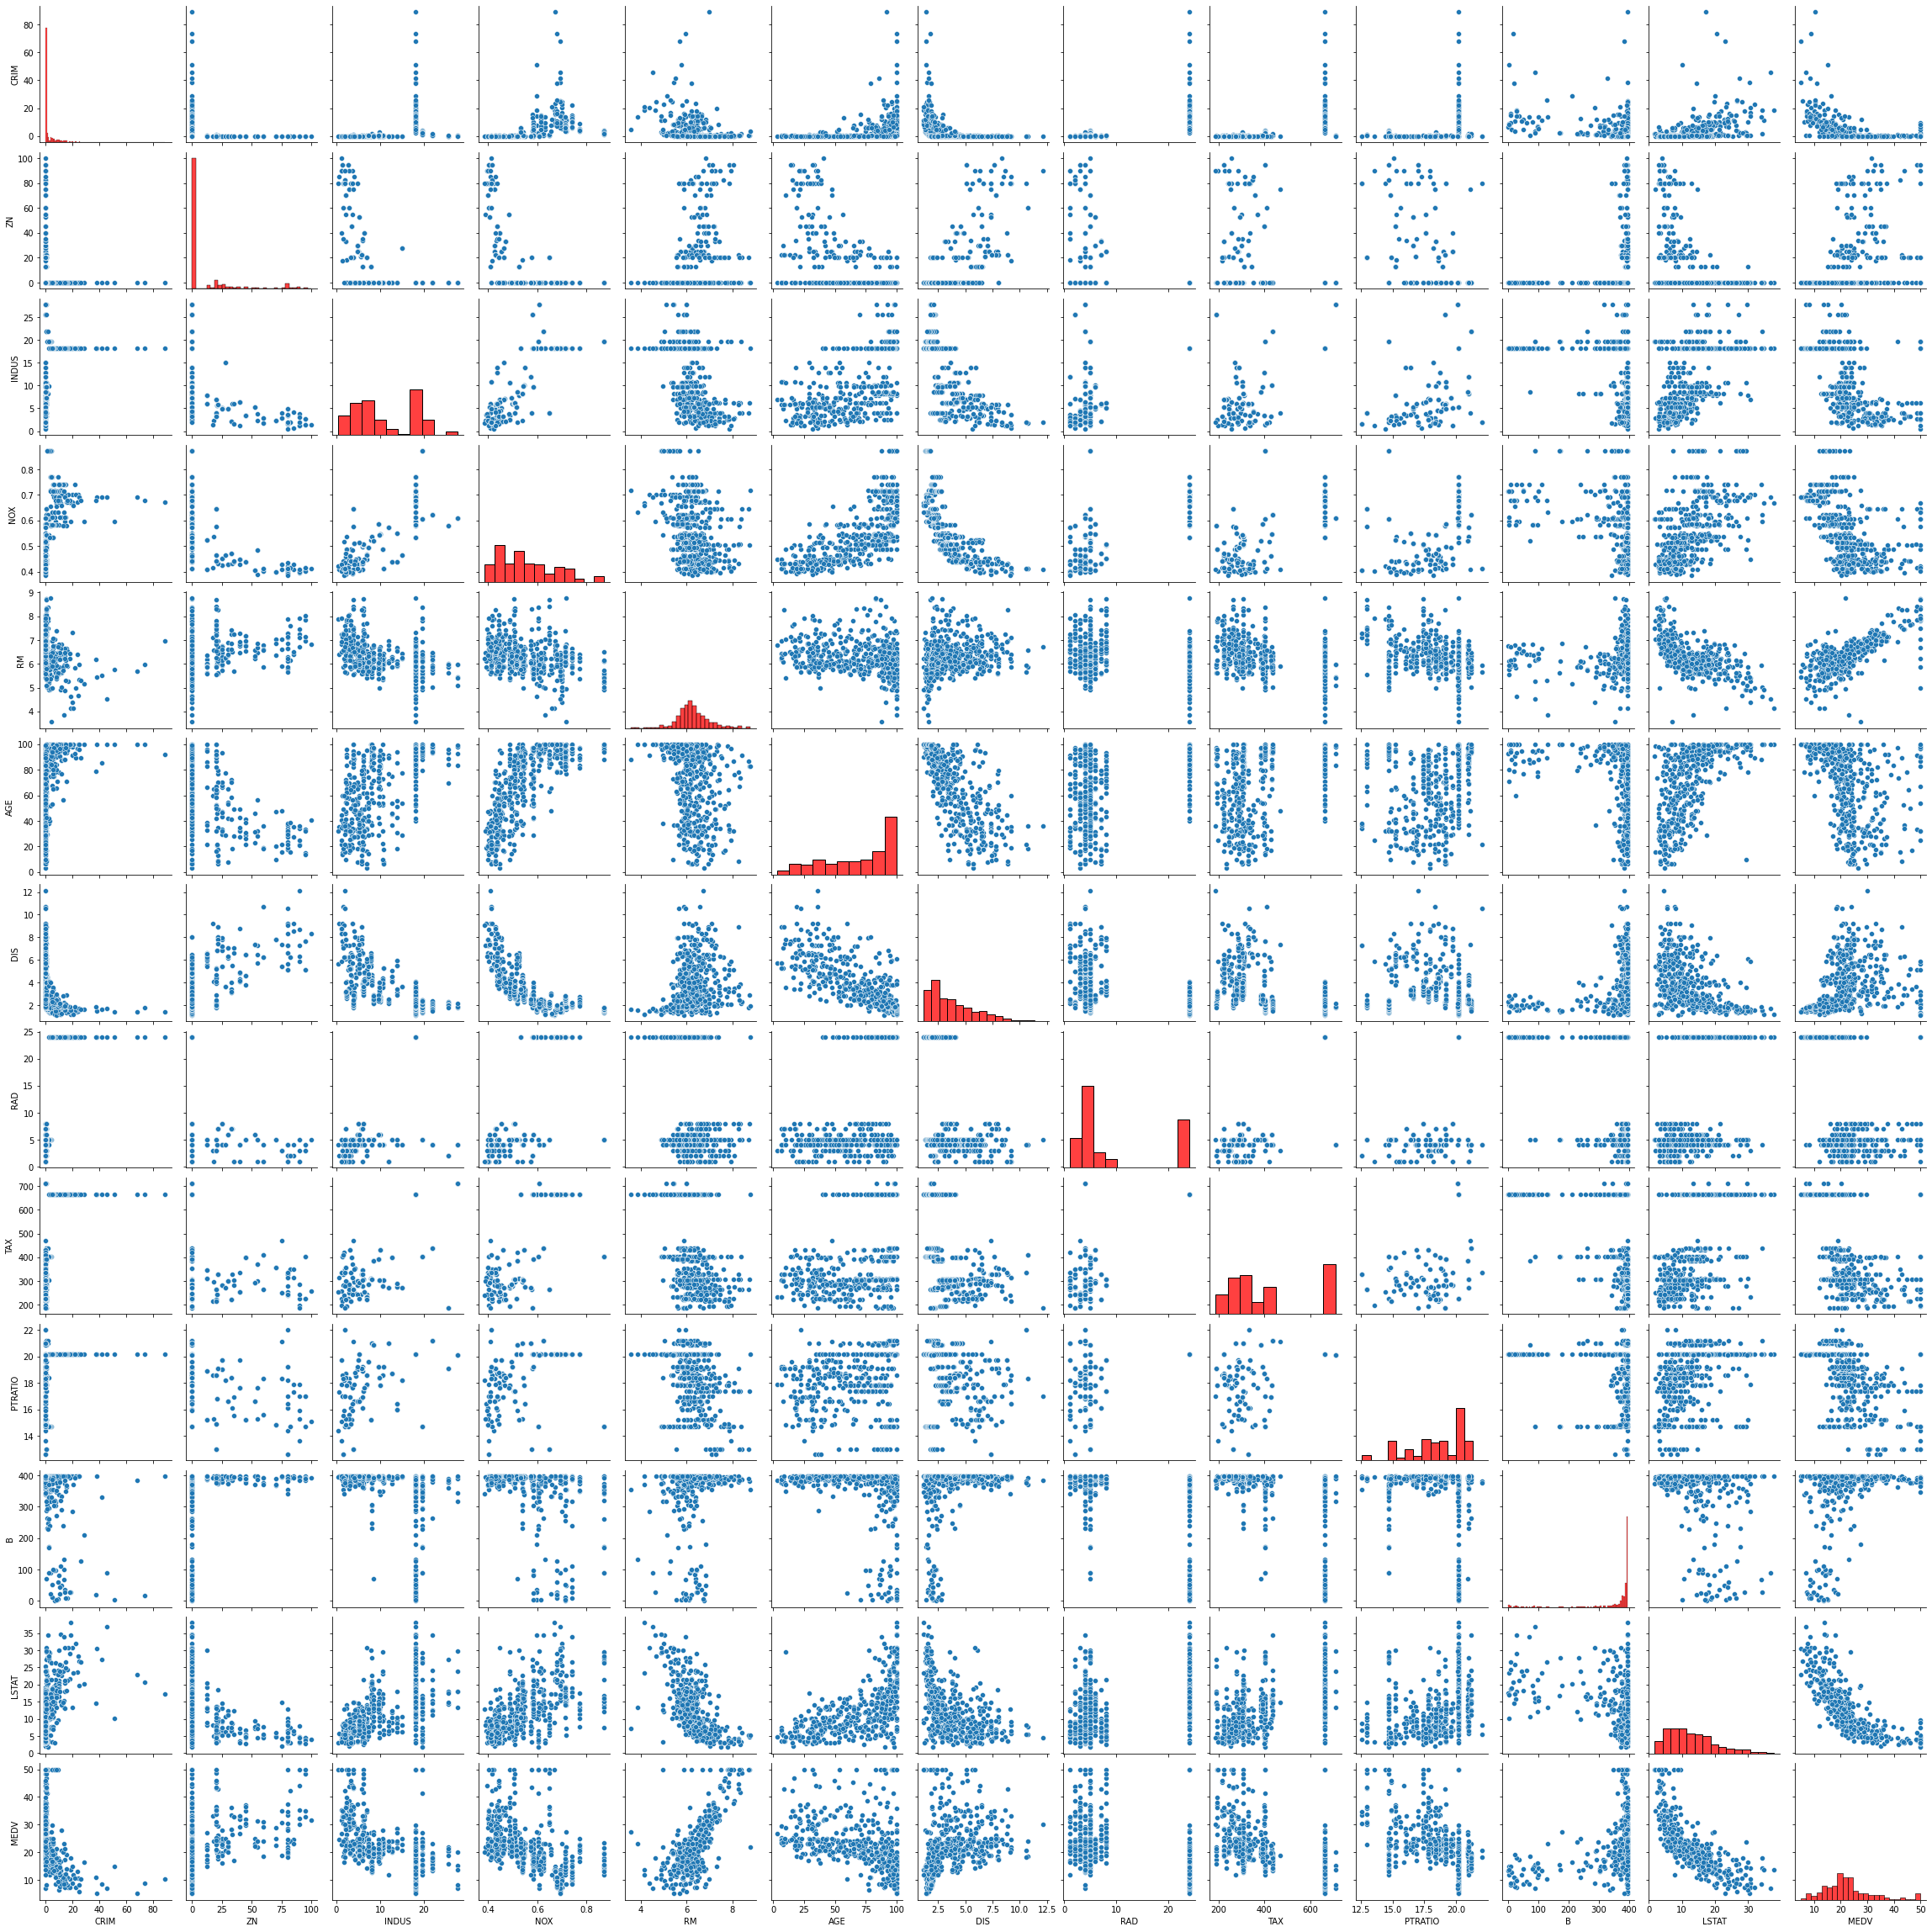

In [5]:
factor_data = df.loc[:, ~df.columns.isin(['CHAS'])]

sns.pairplot(factor_data, diag_kws={'color':'red'})

Pythonic plotting method. Clicking on the plot allows us to zoom on an area of interest.

* AGE is highly left skewed, meaning a lot of homes in our dataset were built prior to 1940.
* DIS is highly right skewed, meaning many of the homes are in close proximity to Boston employment centers. We might venture to say that being close to one, indicates that there is more need for one.
* INDUS appears to overall have a fairly low proportion of non-retail business acres, although we see a spike ~18%.
* LSTAT is right skewed, reaching its peak between 5-20%.
* MEDV is slightly right skewed, reaching its peak between 17-25K dollars.
* NOX - is a multi-modal distribution, concentrated between 0.4-0.6, with its last significant spike ~0.7.
* PTRATIO - is a relatively uniform distribution ranging from 12.5-22.5 with a significant spike ~21.
* RAD - is a bimodal distribution with peaks ~5 and ~22.5. It appears that individuals are either very close OR very far from radial highways.
* RM - is a relatively normal distribution with a peak ~6 and the greatest concentration of rooms between 5.5-7.
* TAX- is a bimodal distribution with one peak ~300 and a larger peak ~650. There looks to be a split where either the tax value is on the lower end, or very high (600K+).
* ZN - is highly right skewed and may be adjusted as a categorical variable (0,1). It looks like the majority of land is not zoned for large lots
* B - is highly left skewed and may also be adjusted as a categorical variable (0,1).
* CRIM - is highly right skewed and may also be adjusted as a categorical variable (0,1).

In [6]:
y, X = dmatrices('MEDV ~ AGE+DIS+INDUS+LSTAT+NOX+PTRATIO+RAD+RM+TAX+ZN+B+CRIM', data=df, return_type='dataframe')

#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 

#calculate VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

     variable         VIF
0   Intercept  606.989876
1         AGE    3.135829
2         DIS    3.840045
3       INDUS    4.030085
4       LSTAT    2.998059
5         NOX    4.465502
6     PTRATIO    1.779519
7         RAD    7.100703
8          RM    1.988388
9         TAX    8.851312
10         ZN    2.309354
11          B    1.343060
12       CRIM    1.750447


From above we can extend:

* Low correlation: PTRATIO, RM, B, CRIM
* Moderate correlation: AGE, DIS, INDUS, LSTAT, NOX, ZN
* High correlation: RAD, TAX

We may eliminate the variables with high multicollinearity to improve the accuracy of our model.

Let's visualize the multicollinearity and correlation with our target (MEDV) to explore further:

In [7]:
# Visualize relationship between variables and `Score` (ie. ranked correlation)
df.corr().style.background_gradient(cmap="Blues")

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.191178,0.401863,-0.054355,0.417130,-0.219150,0.354342,-0.374166,0.624765,0.580595,0.281110,-0.381411,0.444943,-0.391363
ZN,-0.191178,1.000000,-0.531871,-0.037229,-0.513704,0.320800,-0.563801,0.656739,-0.310919,-0.312371,-0.414046,0.171303,-0.414193,0.373136
INDUS,0.401863,-0.531871,1.000000,0.059859,0.764866,-0.390234,0.638431,-0.711709,0.604533,0.731055,0.390954,-0.360532,0.590690,-0.481772
CHAS,-0.054355,-0.037229,0.059859,1.000000,0.075097,0.104885,0.078831,-0.093971,0.001468,-0.032304,-0.111304,0.051264,-0.047424,0.181391
NOX,0.417130,-0.513704,0.764866,0.075097,1.000000,-0.302188,0.731548,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.582641,-0.427321
RM,-0.219150,0.320800,-0.390234,0.104885,-0.302188,1.000000,-0.247337,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.614339,0.695360
AGE,0.354342,-0.563801,0.638431,0.078831,0.731548,-0.247337,1.000000,-0.744844,0.458349,0.509114,0.269226,-0.275303,0.602891,-0.394656
DIS,-0.374166,0.656739,-0.711709,-0.093971,-0.769230,0.205246,-0.744844,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.493328,0.249929
RAD,0.624765,-0.310919,0.604533,0.001468,0.611441,-0.209847,0.458349,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.479541,-0.381626
TAX,0.580595,-0.312371,0.731055,-0.032304,0.668023,-0.292048,0.509114,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.536110,-0.468536


We use the above correlation map to visualize multicollinearity and the variables most correlated with median value (MEDV):

* there is moderate multicollinearity between many variables and we confirm RAD and TAX are deeply correlated. Greater accessibility --> higher taxes. We'll keep just one.
* LSTAT has a strongly negative correlation and RM a strongly positive correlation with MEDV. A higher proportion of low income individuals drives down median home values and a greater number of rooms drives up median home value.

*How might we interpret this?*

It makes sense. Greater 

**EDA summary**:
* NULL presence in CRIM, ZN, INDUS, CHAS, AGE, and LSTAT
* we may deal with highly skewed variables by generating flag variables (ie. high crime)
* there are outliers and highly correlated variables.

Thus, data cleaning is definitely in order.

### Baseline Model

To start, we train-test split our data and evaluate the performance of our baseline, un-cleaned model:

In [8]:
# Drop impertinent rows (high NULL presence)
df = df.dropna()

# initialize X, y
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# verify dataset shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(315, 13)
(79, 13)
(315,)
(79,)


We confirm a successful train-test split and proceed to model baselining:

In [9]:
# instantiate, train model, and cast predictions
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)

r_sq = model_1.score(X_train, y_train)
print("Train data model performance ...")
print(f"Coefficient of determination: {r_sq}")

# assess model performance
print("")
print("Test data model performance ...")
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean squared error:', metrics.mean_squared_error(y_test, y_pred))
print('Root mean squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Train data model performance ...
Coefficient of determination: 0.7545891471058722

Test data model performance ...
Mean absolute error: 3.2507977378004815
Mean squared error: 18.36147117341063
Root mean squared error: 4.285028724922463


That's our baseline. After cleaning, or at each step, we can use these metrics to assess impact.

Next, let's deal with outliers:

In [10]:
# identify outliers using IsolationForest
iso = IsolationForest(contamination=float(0.1),random_state=1)
anomaly = iso.fit_predict(X_train)

# select non-outlier rows
X_train, y_train = X_train[anomaly != -1], y_train[anomaly != -1]

# summarize dataset shapes (after outliers have been removed)
print(X_train.shape, y_train.shape)

(283, 13) (283,)


c:\users\magnu\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [11]:
# instantiate, train model, and cast predictions
model_2 = LinearRegression()
model_2.fit(X_train, y_train)
y_pred2 = model_2.predict(X_test)

r_sq = model_2.score(X_train, y_train)
print("Train data model performance ...")
print(f"Coefficient of determination: {r_sq}")

# assess model performance
print("")
print("Test data model performance ...")
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred2))
print('Mean squared error:', metrics.mean_squared_error(y_test, y_pred2))
print('Root mean squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

Train data model performance ...
Coefficient of determination: 0.7891386959830122

Test data model performance ...
Mean absolute error: 3.215719038403655
Mean squared error: 18.847093005103634
Root mean squared error: 4.3413238770107485


Observations:
* Coefficient of determination improved from 0.754 to 0.789
* MAE improved from 3.25 to 3.21 while RMSE rose from 4.28 to 4.34

**Outlier-removal via IsolationForest had a majority positive outcome.**

Next, we remove redundant features:

In [12]:
# Remove impertinent features (ie. CHAS, TAX) and initialize new df for transformations
X_train = X_train.drop(columns=['CHAS', 'TAX'])
X_test = X_test.drop(columns=['CHAS', 'TAX'])

# instantiate, train model, and cast predictions
model_3 = LinearRegression()
model_3.fit(X_train, y_train)
y_pred3 = model_3.predict(X_test)

r_sq = model_3.score(X_train, y_train)
print("Train data model performance ...")
print(f"Coefficient of determination: {r_sq}")

# assess model performance
print("")
print("Test data model performance ...")
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred3))
print('Mean squared error:', metrics.mean_squared_error(y_test, y_pred3))
print('Root mean squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred3)))

Train data model performance ...
Coefficient of determination: 0.7822694808614316

Test data model performance ...
Mean absolute error: 3.368333464134097
Mean squared error: 20.673291770250135
Root mean squared error: 4.546789171519847


Removing 'CHAS' and 'TAX' led to simpler model with a slightly worse performance.

As a final data cleaning and preparation step, we experiment with feature engineering:

In [14]:
# generate a feature for "undesirable location"
crime_75_pct = np.percentile(df['CRIM'],75)
lstat_75_pct = np.percentile(df['LSTAT'],75)
X_train['UNDESIRABLE'] = (X_train['CRIM'] >= crime_75_pct) & (X_train['LSTAT'] >= lstat_75_pct)
X_test['UNDESIRABLE'] = (X_test['CRIM'] >= crime_75_pct) & (X_test['LSTAT'] >= lstat_75_pct)

# generate a feature for "desirable location"
dis_75_pct = np.percentile(df['DIS'],75)
rad_25_pct = np.percentile(df['RAD'],25)
ptratio_25_pct = np.percentile(df['PTRATIO'],25)
X_train['DESIRABLE'] = (X_train['DIS'] >= dis_75_pct) & (X_train['RAD'] <= rad_25_pct) & (X_train['PTRATIO'] <= ptratio_25_pct)
X_test['DESIRABLE'] = (X_test['DIS'] >= dis_75_pct) & (X_test['RAD'] <= rad_25_pct) & (X_test['PTRATIO'] <= ptratio_25_pct)

# verify output
# X_train.head()
# X_test.head()

# instantiate, train model, and cast predictions
model_4 = LinearRegression()
model_4.fit(X_train, y_train)
y_pred4 = model_4.predict(X_test)

r_sq = model_4.score(X_train, y_train)
print("Train data model performance ...")
print(f"Coefficient of determination: {r_sq}")

# assess model performance
print("")
print("Test data model performance ...")
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred4))
print('Mean squared error:', metrics.mean_squared_error(y_test, y_pred4))
print('Root mean squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred4)))

Train data model performance ...
Coefficient of determination: 0.7906640111575554

Test data model performance ...
Mean absolute error: 3.2587159706002002
Mean squared error: 19.511987950025752
Root mean squared error: 4.4172375926619285


Feature engineering, by contrast to the last step, increased model complexity while improving MAE and RMSE.

### Conclusion

And there you have it, EDA and regression model optimization all tied up in one for the classic Boston housing dataset.

* EDA-wise, we explored missing values, pair plots, distributions, VIF, and correlation plots.
* We generated our baseline model (after removing NULL rows) and tried feature reduction, outlier handling, feature engineering. 

In the end, we found that not all stones turned over lead to rewards and oftentimes there nuance when making decisions model-wise. There are tradeoffs between model simplicity and model performance. 


**References**
1. [RealPython](https://realpython.com/linear-regression-in-python/)
2. [Intellipaat](https://intellipaat.com/blog/what-is-linear-regression/?US)
3. [Machine Learning Mastery](https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/)